# Model comparison for the Sithas catchment, Gulf of Corinth

**John Armitage**

*In this notebook I analyse three model explorations of the Sithas catchment within the Gulf of Corinth.*

The model used is [HAIL-CAESAR](https://github.com/dvalters/HAIL-CAESAR), which will be shortened to HC. HC is a `C++` version of the `C#` CAESAR-Lisflood model developed by Tom Coulthard and others ([Coulthard et al., 2013](https://doi.org/10.1002/esp.3478)). The advantage of HC is that it can be run on any machine, Linux, Mac OS, Windows, etc. HC is parallelised using OpenMP. It solves for the overland flow of water using the Lisflood FP algorithm of [Bates et al. (2010)](https://doi.org/10.1016/j.jhydrol.2010.03.027), which is a simplification of the shallow water equations for the flow of water over the surface of a landscape. Sediment is subsequently transported down slope either as a single suspended grain size, or as multiple bedloads of different characteristic grain size. Bedload sediment transport follows the empirical [Wilcox & Crowe (2003)](https://doi.org/10.1061/(ASCE)0733-9429(2003)129:2(120)) model for fractional transport of grains. Susspended loads are a linear function of water flux with a constant setling velocity defined.

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import rasterio as rio
import pyvista as pv
import statsmodels.api as sm
from osgeo import gdal
import datetime

sys.path.insert(1, os.path.join(sys.path[0], '..'))
import caesarpy as cp

from pyvista import set_plot_theme
set_plot_theme('document')

## Sithas catchment

The Sithas catchment is on the southern shore of the Gulf of Corinth in Greece. It is a small catchment of the order of 25 km long.

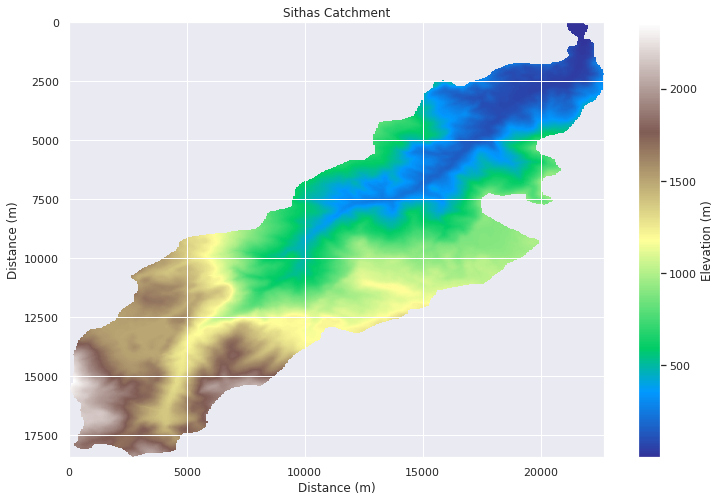

In [2]:
grdfile = '/work/armitagj/runs/caesar-explore/sithas/DEM/removed_pits/DEM_SITHAS_CATCH09-2020_CUT_RESAMPLE_WARP50.tif'
rio_array = rio.open(grdfile)
pix = rio_array.transform[0]
data_array = rio_array.read(1).astype(float) 
data_array[data_array <= 0] = np.nan
extent = [0, np.shape(data_array)[0] * pix, np.shape(data_array)[1] * pix, 0]
sns.set(rc={'figure.figsize':(12, 8)})
plt.figure()
plt.imshow(data_array, aspect='auto', cmap='terrain', extent=extent)
plt.colorbar(label='Elevation (m)')
plt.title('Sithas Catchment')
plt.xlabel('Distance (m)')
plt.ylabel('Distance (m)')
plt.savefig('sithas_DEM.png', dpi=300)
plt.show()

The topographic range is of the order of 2000 m, and the climate is Mediterranean, with some snow during winter. There are regions with very little vegetation. The soil thickness for the catchment is estimated using depth to bedrock estimates of [Shangguan et al., 2017](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016MS000686) the https://soilgrids.org/ database.

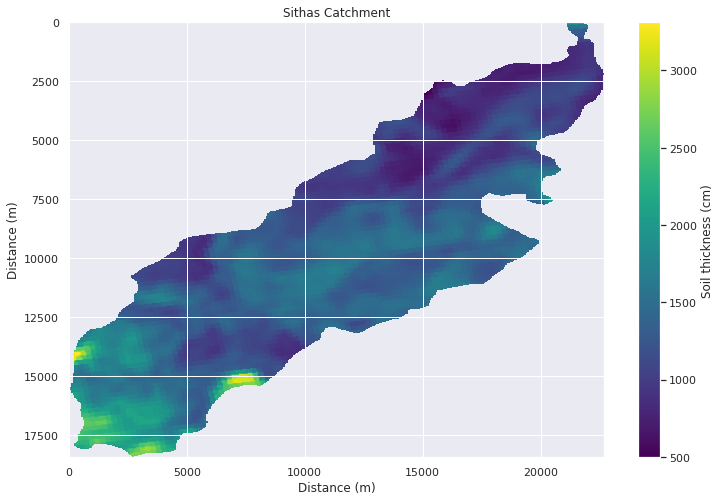

In [3]:
grdfile = '/work/armitagj/runs/caesar-explore/sithas/DEM/removed_pits/DEM_TICKNESS_SOIL09-2020_CUT_SITHAS_RESAMPLE_WARP50.tif'
rio_array = rio.open(grdfile)
pix = rio_array.transform[0]
data_array = rio_array.read(1).astype(float) 
data_array[data_array <= 0] = np.nan
extent = [0, np.shape(data_array)[0] * pix, np.shape(data_array)[1] * pix, 0]
plt.figure()
plt.imshow(data_array, aspect='auto', cmap='viridis', extent=extent)
plt.colorbar(label='Soil thickness (cm)')
plt.title('Sithas Catchment')
plt.xlabel('Distance (m)')
plt.ylabel('Distance (m)')
plt.savefig('sithas_bedrock_DEM.png', dpi=300)
plt.show()

There is a long history of meteorological measurements in the region, with the nearest station, Chalkio, having an uninterrupted 50 year record of precipitation.

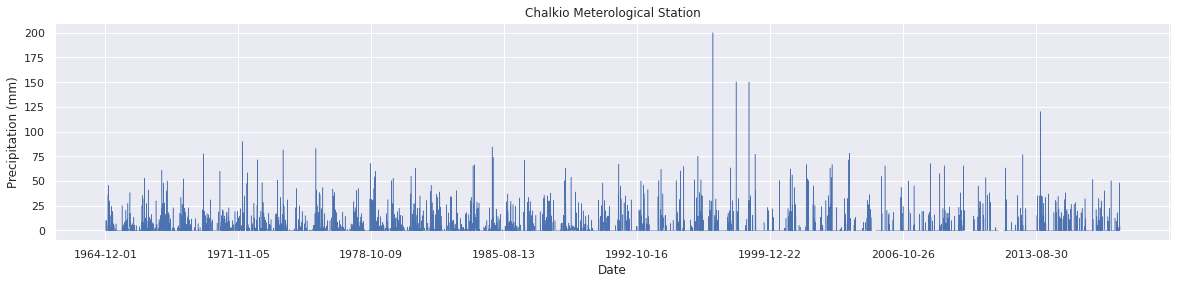

In [4]:
file = '/work/armitagj/runs/caesar-explore/sithas/input_data/Chalkio_station.txt'
chalkio = pd.read_csv(file, sep=' |,', index_col=False, comment='#', engine='python')
chalkio = chalkio.set_index('date')
sns.set(rc={'figure.figsize':(20, 4)})
plt.figure()
ax = chalkio['rainfall'].plot(linewidth=0.5)
ax.set_ylabel('Precipitation (mm)')
ax.set_xlabel('Date')
plt.title('Chalkio Meterological Station')
plt.savefig('chalkio-rainfall.png')
plt.show()

In [5]:
d = 3e-5
rhos = 2500
rhol = 1000
mu = 1e-6
g = 9.81

s = 1500/1000
vturb = s*g*d*d/(18*mu + np.power(0.75*s*g*np.power(d,3),.5))
vlam = s*g*d*d/(18*mu)
print('Stokes Law setling: v = {}; Turbulent setling: v = {}'.format(vlam, vturb))

Stokes Law setling: v = 0.00073575; Turbulent setling: v = 0.0007140941314864857


## Sediment properties

The code runs with one grain size fraction that is transported as a suspended load and multiple grain size fractions that are transported as bedload. The transport of sediment uses the model of [Wilcock and Crowe (2003)](#), where the flux of sediment transported is given by,
$$q_{i} = \frac{F_{i}UW}{\left(s-1\right)g} $$
where $s = \left(\rho_{s}-\rho_{l}\right)/\rho_{l}$ and $F_{i}$ is the fraction of the grain size, $U$ is the shear velocity, $g$ is acceleration due to gravity, $\rho_{s}$ is the sediment desity, $\rho_{l}$ is the liquid density. Finally $W$ is a function defined in [Wilcock and Crowe (2003)](#).

### Bed load

Up to 8 sediment grain sizes can be transported as bed load. Bed load is transported down the slope on the base of the wetted area to the next cell where all material is deposited.

### Suspended load

Only one grain size is treated as a suspended load and it is transported with the water flux term (not the topographic slope). It then drops vertically with a velocity that is set by the user, and only the proportion that reaches the base of the water column within the time step is deposited.

### Model input

There are four facies, clay, silt, sand and gravel. I have either modelled clay and silt together as mud, or keep them separate. I have assumed a fall velocity of 0.033 m/sec. This choice is too high, in retrospect the settling velocity should be around 0.00083 m/sec for a 30 micron particle (using this web-app http://www.filtration-and-separation.com/settling/sediment.asp). Assuming laminar flow, from Stokes Law the settling velocity can be calculated as:
$$ v = \frac{sgd^{2}}{18\mu} $$
where $v$ is the setling velocity, $d$ is grain diameter, and $\mu$ is the liquid kinematic viscosity. Assuming the density of the suspended sediment is 2500 kg/m³, and is has a diameter of 30 microns the setling velocity is 0.00073 m/sec. For settling in a turbulent flow the velocity can be given by [(Ferguson and Church 2004)](https://doi.org/10.1306/051204740933):
$$ v = \frac{sgd^{2}}{18\mu + \sqrt{0.75sgd^{3}}} $$
For the same particle this gives a setling velocity of 0.00071 m/sec.

**I will therefore re-run the models with a more appropriate fall velocity**. An any case the input sediment parameters are either:

| Facies | Proportion | Grain size (m) | Fall velocity |
| --- | --- | --- | --- |
| Suspended | 0.87 | 0.00003 | 0.033 |
| Sand | 0.13 | 0.0005 | - |
| Gravel | 0.01 | 0.004 | - |

or,

| Facies | Proportion | Grain size (m) | Fall velocity |
| --- | --- | --- | --- |
| Clay | 0.34 | 0.000002 | 0.033 |
| Silt | 0.53 | 0.000032 | - |
| Sand | 0.13 | 0.0005 | - |
| Gravel | 0.01 | 0.004 | - |

## HC with no depth to bedrock and three grain sizes (suspended, sand and gravel)

The first model run is HC with no depth to bedrock. This means that there is always transportable sediment. It is assumed that there are three characteristic grains: an aggregation of silt and clay that is treated as suspended load, sand, and gravel. The proportions of this material are 86%, 13% and 1%, with characteristic grain sizes of 30 $\mu$m, 400 $\mu$m, and 4 mm. The settling velocity for the suspended load is 0.033 ms$^{-1}$.

The model is run for 4942 days, with the precipitation record starting from the year 1964. This length of model is chosen as it is the number of days reached after 120 hours of calculation on `ENER440` (I am limited to one compute node, 36 cpus, as the code is parellised using OpenMP). 

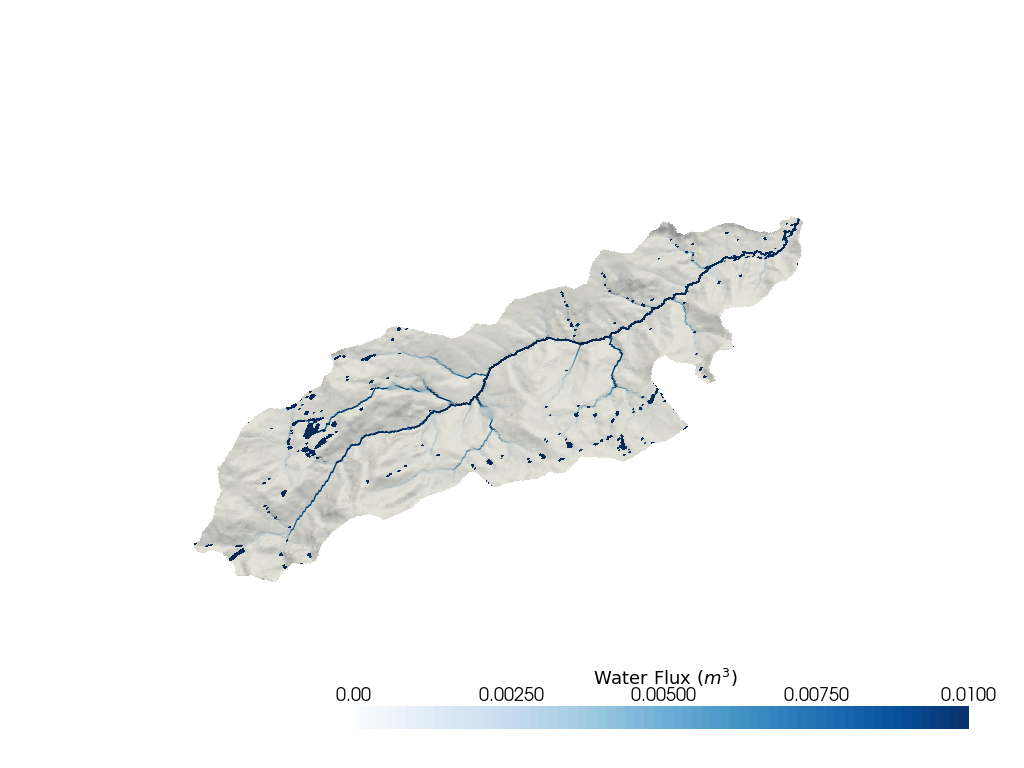

[(1069.0495742663963, 29034.111992089165, 53318.503286205276),
 (9225.0, 11075.0, 1186.6665744781494),
 (0.2969121238555084, -0.8875739108330448, 0.35221547881395754)]

In [6]:
ascfile = '/work/armitagj/runs/caesar-explore/ener440/sithas/results/Elevations7344000.asc'
ncols, nrows, geotransform, data_array = cp.demio.asc2numpy(ascfile)
dXY = geotransform[1]
xcorner = np.linspace(0.5*dXY, (ncols-0.5)*dXY, ncols)
ycorner = np.linspace(0.5*dXY, (nrows-0.5)*dXY, nrows)
z = np.fliplr(data_array)
x,y = np.meshgrid(xcorner, ycorner)
grid = pv.StructuredGrid(x, y, z)
d = np.zeros_like(grid.points)
d[:, 1] = grid.points[:, 2]

ascfile = '/work/armitagj/runs/caesar-explore/ener440/sithas/results/WaterDepths7344000.asc'
ncols, nrows, geotransform, data_array = cp.demio.asc2numpy(ascfile)
water = pv.StructuredGrid(x, y, np.fliplr(data_array))
d = np.zeros_like(water.points)
d[:, 1] = water.points[:, 2]

cpos = [(1069.0495742663963, 29034.111992089165, 53318.503286205276),
        (9225.0, 11075.0, 1186.6665744781494),
        (0.29691212385550847, -0.887573910833045, 0.3522154788139576)]

p = pv.Plotter(notebook=True)
p.add_mesh(grid, scalars=d[:,1], cmap='Blues', clim=[0,.01])
p.camera_position = cpos
p.add_scalar_bar(title='Water Flux ($m^3$)')
p.show(screenshot='caesar-water.png')

The model output after 4942 days shows that the initial DEM contains pits within which lakes form. This poses a problem: how to deal with these pits. The DEM could be treated to *pop* pits and create a surface over which water does not collect. In reality this region is karstic and infiltration and groundwater pathways will exist. 

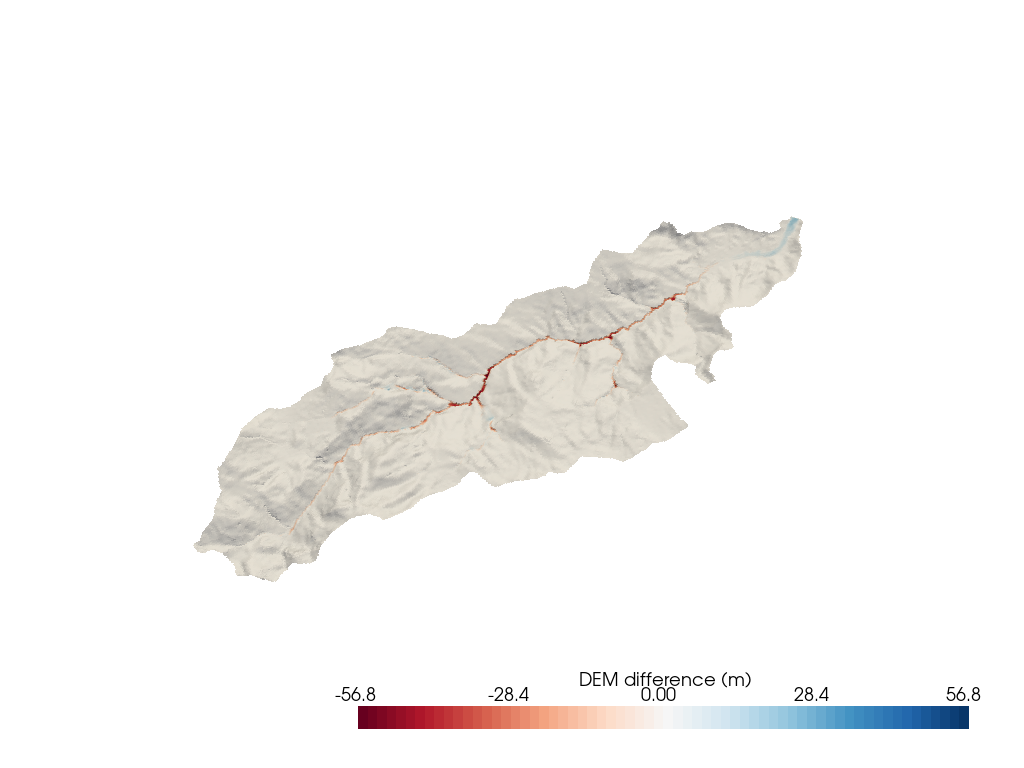

[(1069.0495742663963, 29034.111992089165, 53318.503286205276),
 (9225.0, 11075.0, 1186.6665744781494),
 (0.2969121238555084, -0.8875739108330448, 0.35221547881395754)]

In [7]:
ascfile = '/work/armitagj/runs/caesar-explore/ener440/sithas/results/Elevations7344000.asc'
ncols, nrows, geotransform, data_array = cp.demio.asc2numpy(ascfile)
dXY = geotransform[1]
xcorner = np.linspace(0.5*dXY, (ncols-0.5)*dXY, ncols)
ycorner = np.linspace(0.5*dXY, (nrows-0.5)*dXY, nrows)
z = np.fliplr(data_array)
x,y = np.meshgrid(xcorner, ycorner)
grid = pv.StructuredGrid(x, y, z)
d = np.zeros_like(grid.points)
d[:, 1] = grid.points[:, 2]

ascfile = '/work/armitagj/runs/caesar-explore/ener440/sithas/results/Elevations0.asc'
ncols, nrows, geotransform, data_array = cp.demio.asc2numpy(ascfile)
z0 = pv.StructuredGrid(x, y, np.fliplr(data_array))
d0 = np.zeros_like(z0.points)
d0[:, 1] = z0.points[:, 2]

cpos = [(1069.0495742663963, 29034.111992089165, 53318.503286205276),
        (9225.0, 11075.0, 1186.6665744781494),
        (0.29691212385550847, -0.887573910833045, 0.3522154788139576)]

clim = np.nanmax(np.abs(d[:,1] - d0[:,1]))
p = pv.Plotter(notebook=True)
p.add_mesh(grid, scalars=d[:,1] - d0[:,1], cmap='RdBu', clim=[-clim, clim])
p.camera_position = cpos
p.add_scalar_bar(title='DEM difference (m)')
p.show(screenshot='caesar.png')

Without a bedrock surface the HC model simulates up to 60 m of incision within the *4945* day duration of the model run. **I think this is likely too much erosion** 

<Figure size 1080x1080 with 0 Axes>

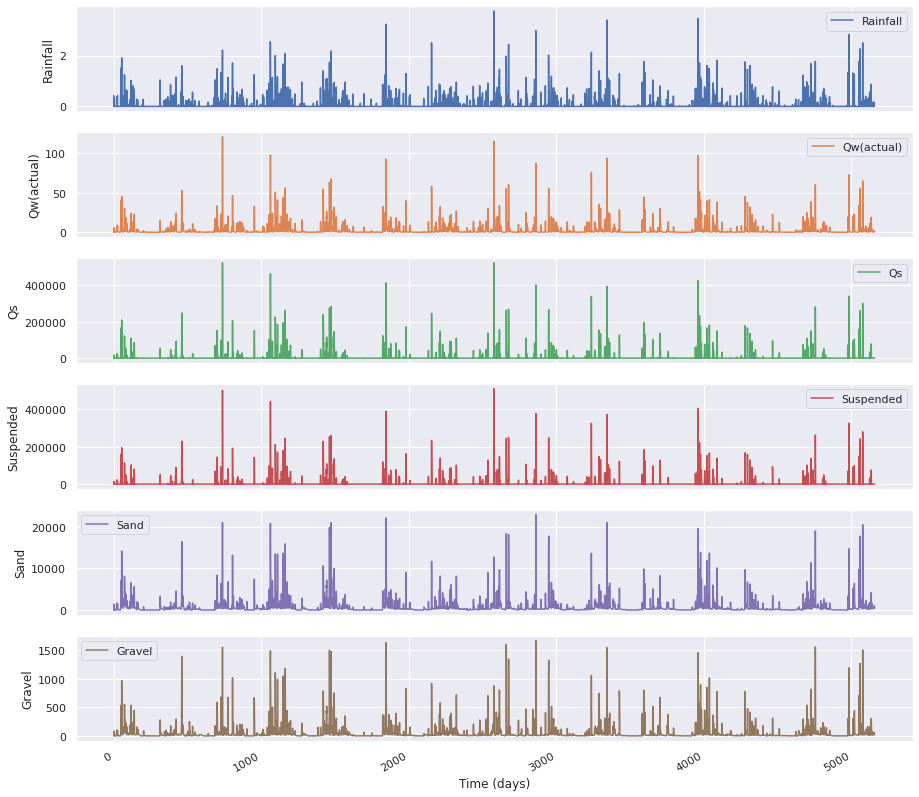

In [8]:
file = '/work/armitagj/runs/caesar-explore/ener440/sithas/results/Sithas_v7.dat'
sithas_ = pd.read_csv(file, sep=' ', index_col=False,
                       names=['Time Step', 'Qw(actual)', 'Qw(expected)', 'Blank', 'Qs', 'Suspended', 'Sand', 'Gravel'])
file = '/work/armitagj/runs/caesar-explore/ener440/sithas/input_data/Chalkio_rain.txt'
sithas_rain = pd.read_csv(file, sep=' ', index_col=False,
                       names=['Rainfall'])
sithas_all = pd.concat([sithas_, sithas_rain], axis=1, sort=False).dropna()
sns.set(rc={'figure.figsize':(15, 15)})
plt.figure()
cols_plot = ['Rainfall', 'Qw(actual)', 'Qs', 'Suspended', 'Sand', 'Gravel']
axes = sithas_all[cols_plot].plot(marker='', alpha=1, subplots=True)
i = 0
for ax in axes:
    ax.set_ylabel(cols_plot[i])
    i += 1
plt.xlabel('Time (days)')
plt.savefig('sithas_tseries.png')
plt.show()

The time series plotted above shows that HC responds to each season of increased precipitation. The response is filtered by the transformation from rainfall to water flux. It is perhaps interesting to see if the relationship between rainfall and sediment yield is linear or non-linear:

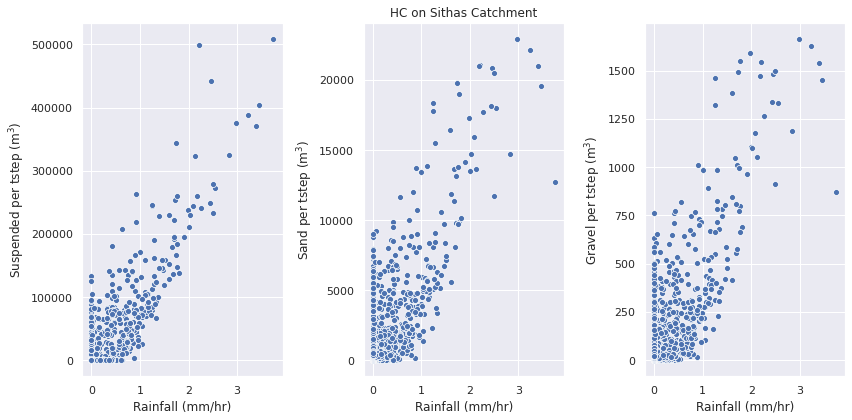

In [9]:
plt.figure(figsize=(12,6))
ax1 = plt.subplot(131)
g = sns.scatterplot(sithas_all['Rainfall'], sithas_all['Suspended'], ax=ax1)
g.set_xlabel(g.get_xlabel() + ' (mm/hr)')
g.set_ylabel(g.get_ylabel() + ' per tstep (m$^3$)')
ax2 = plt.subplot(132)
g = sns.scatterplot(sithas_all['Rainfall'], sithas_all['Sand'], ax=ax2)
g.set_xlabel(g.get_xlabel() + ' (mm/hr)')
g.set_ylabel(g.get_ylabel() + ' per tstep (m$^3$)')
plt.title('HC on Sithas Catchment')
ax3 = plt.subplot(133)
g = sns.scatterplot(sithas_all['Rainfall'], sithas_all['Gravel'], ax=ax3)
g.set_xlabel(g.get_xlabel() + ' (mm/hr)')
g.set_ylabel(g.get_ylabel() + ' per tstep (m$^3$)')
plt.tight_layout()
plt.savefig('sithas.png')
plt.show()

In [10]:
windows = [3, 5, 10]
for window in windows:
    
    sithas_all['Rainfall Rolling Std. ' + str(window)] = sithas_all['Rainfall'].rolling(window).std().values
    sithas_all['Rainfall Rolling Mean. ' + str(window)] = sithas_all['Rainfall'].rolling(window).mean().values
    sithas_all['Rainfall Rolling Median. ' + str(window)] = sithas_all['Rainfall'].rolling(window).median().values
    
    sithas_all['Suspended Rolling Std. ' + str(window)] = sithas_all['Suspended'].rolling(window).std().values
    sithas_all['Suspended Rolling Mean. ' + str(window)] = sithas_all['Suspended'].rolling(window).mean().values
    sithas_all['Suspended Rolling Median. ' + str(window)] = sithas_all['Suspended'].rolling(window).median().values
    
    sithas_all['Sand Rolling Std. ' + str(window)] = sithas_all['Sand'].rolling(window).std().values
    sithas_all['Sand Rolling Mean. ' + str(window)] = sithas_all['Sand'].rolling(window).mean().values
    sithas_all['Sand Rolling Median. ' + str(window)] = sithas_all['Sand'].rolling(window).median().values
    
    sithas_all['Gravel Rolling Std. ' + str(window)] = sithas_all['Gravel'].rolling(window).std().values
    sithas_all['Gravel Rolling Mean. ' + str(window)] = sithas_all['Gravel'].rolling(window).mean().values
    sithas_all['Gravel Rolling Median. ' + str(window)] = sithas_all['Gravel'].rolling(window).median().values

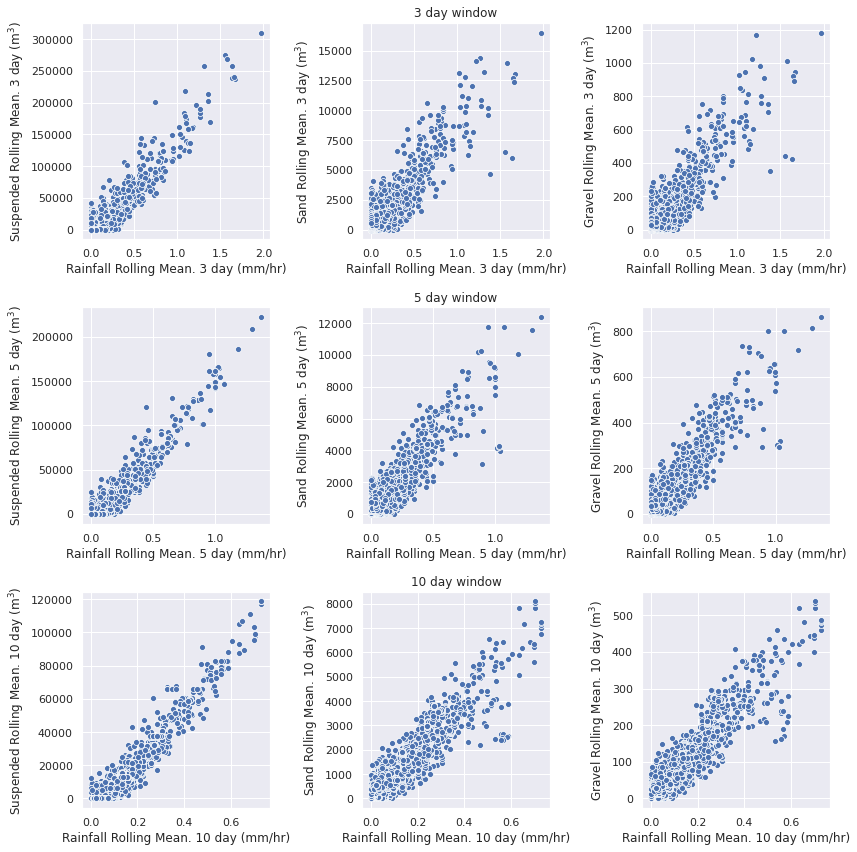

In [11]:
plt.figure(figsize=(12,12))

nplot = 330
for window in windows:
    nplot += 1
    ax1 = plt.subplot(nplot)
    g = sns.scatterplot(sithas_all['Rainfall Rolling Mean. ' + str(window)],
                        sithas_all['Suspended Rolling Mean. ' + str(window)], ax=ax1)
    g.set_xlabel(g.get_xlabel() + ' day (mm/hr)')
    g.set_ylabel(g.get_ylabel() + ' day (m$^3$)')
    nplot += 1
    ax2 = plt.subplot(nplot)
    g = sns.scatterplot(sithas_all['Rainfall Rolling Mean. ' + str(window)],
                        sithas_all['Sand Rolling Mean. ' + str(window)], ax=ax2)
    g.set_xlabel(g.get_xlabel() + ' day (mm/hr)')
    g.set_ylabel(g.get_ylabel() + ' day (m$^3$)')
    plt.title(str(window) + ' day window')
    nplot += 1
    ax3 = plt.subplot(nplot)
    g = sns.scatterplot(sithas_all['Rainfall Rolling Mean. ' + str(window)],
                        sithas_all['Gravel Rolling Mean. ' + str(window)], ax=ax3)
    g.set_xlabel(g.get_xlabel() + ' day (mm/hr)')
    g.set_ylabel(g.get_ylabel() + ' day (m$^3$)')
    
plt.tight_layout()
plt.show()

The initial model run allows a first look at how HC simulates catchment response to precipitation change on a daily bases. Bedload sediment flux is expected to be proportional to the water flux raised to the power of 9/5 from the rules used within the model. Sediment flux is also a function of local topographic slope. The sediment output of the model domain responds linearly to change in precipitation. Above I plot the relationship between the rolling mean over various window sizes. It can be seen that this reduces the spread in the correlation, suggesting that there is not a direct impact from daily events, but a cumulative impact.

Right now I would venture to say that to a first order the HC model would suggest that there is a linear relationship between sediment yield and precipitation. There is a significant variation within this relationship however, that would show that some storms would lead to significant sediment delivery to the Gulf of Corinth, and some that wont. It is possibly a bit premature however to read too much into this early model.

## HC with no depth to bedrock and four grain sizes (clay, silt, sand and gravel)

In this case clay is the only particle that is transported in suspension. This is not the best choice because I would expect silt to be suspended as well. However it gives interesting non-linear results. 

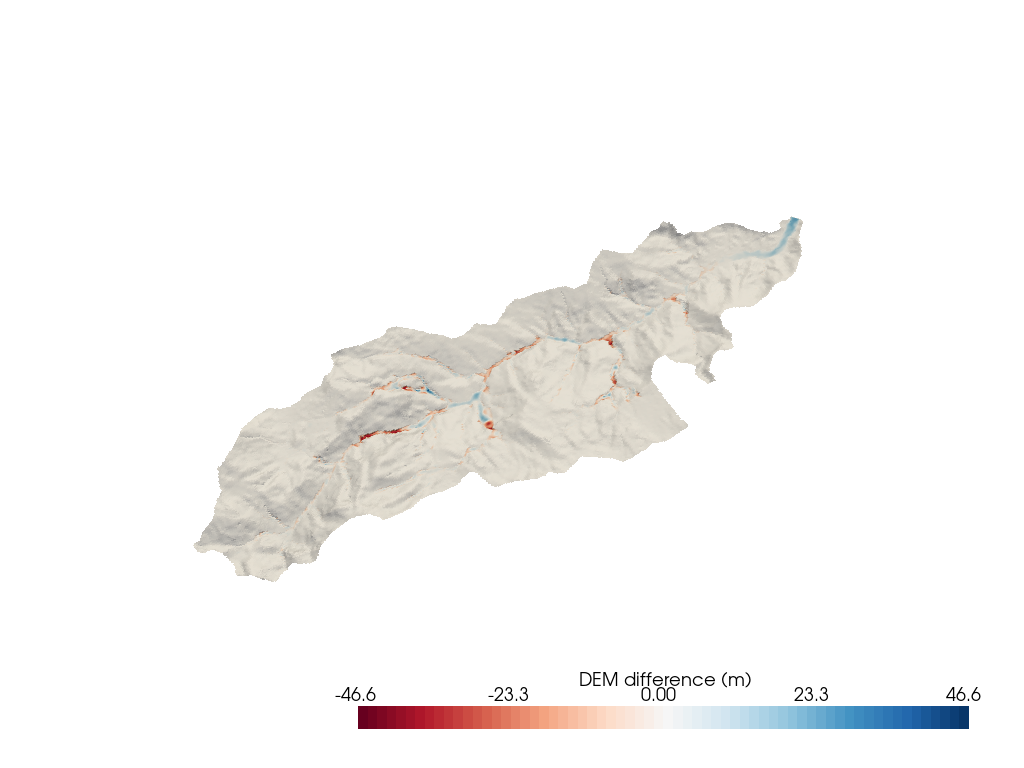

[(1069.0495742663963, 29034.111992089165, 53318.503286205276),
 (9225.0, 11075.0, 1186.6665744781494),
 (0.2969121238555084, -0.8875739108330448, 0.35221547881395754)]

In [12]:
ascfile = '/work/armitagj/runs/caesar-explore/ener440/sithas_4grains/results/Elevations7344000.asc'
ncols, nrows, geotransform, data_array = cp.demio.asc2numpy(ascfile)
dXY = geotransform[1]
xcorner = np.linspace(0.5*dXY, (ncols-0.5)*dXY, ncols)
ycorner = np.linspace(0.5*dXY, (nrows-0.5)*dXY, nrows)
z = np.fliplr(data_array)
x,y = np.meshgrid(xcorner, ycorner)
grid = pv.StructuredGrid(x, y, z)
d = np.zeros_like(grid.points)
d[:, 1] = grid.points[:, 2]

ascfile = '/work/armitagj/runs/caesar-explore/ener440/sithas_4grains/results/Elevations0.asc'
ncols, nrows, geotransform, data_array = cp.demio.asc2numpy(ascfile)
z0 = pv.StructuredGrid(x, y, np.fliplr(data_array))
d0 = np.zeros_like(z0.points)
d0[:, 1] = z0.points[:, 2]

cpos = [(1069.0495742663963, 29034.111992089165, 53318.503286205276),
        (9225.0, 11075.0, 1186.6665744781494),
        (0.29691212385550847, -0.887573910833045, 0.3522154788139576)]

clim = np.nanmax(np.abs(d[:,1] - d0[:,1]))
p = pv.Plotter(notebook=True)
p.add_mesh(grid, scalars=d[:,1] - d0[:,1], cmap='RdBu', clim=[-clim, clim])
p.camera_position = cpos
p.add_scalar_bar(title='DEM difference (m)')
p.show(screenshot='caesar.png')

<Figure size 1080x1080 with 0 Axes>

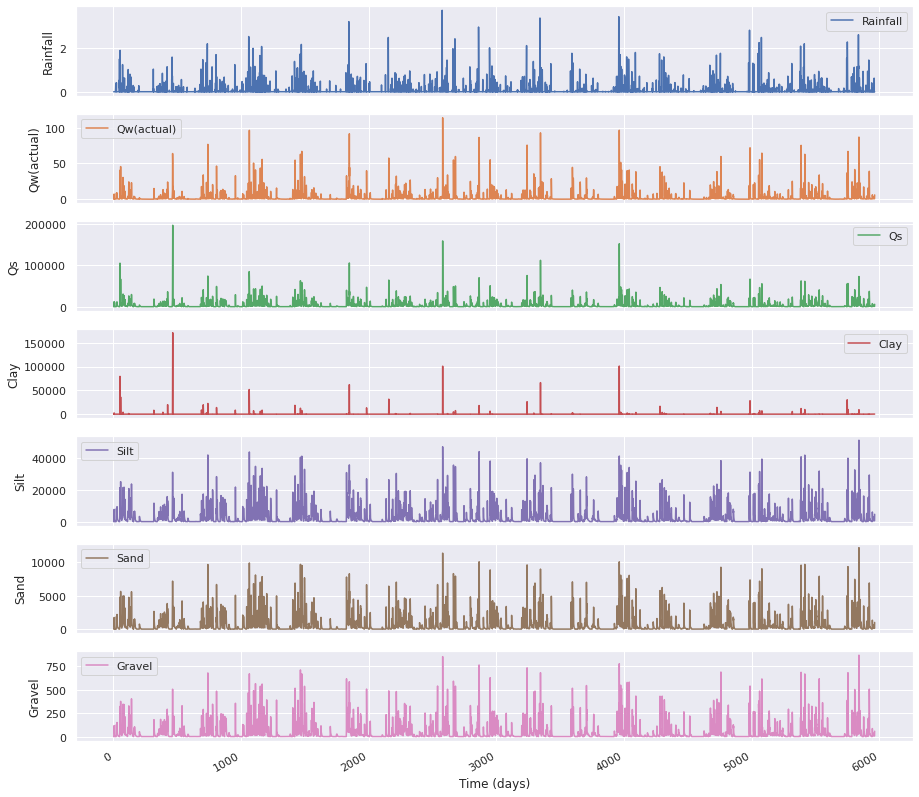

In [13]:
file = '/work/armitagj/runs/caesar-explore/ener440/sithas_4grains/results/Sithas_v7.dat'
sithas_ = pd.read_csv(file, sep=' ', index_col=False,
                       names=['Time Step', 'Qw(actual)', 'Qw(expected)', 'Blank', 'Qs', 'Clay', 'Silt', 'Sand', 'Gravel'])
file = '/work/armitagj/runs/caesar-explore/ener440/sithas/input_data/Chalkio_rain.txt'
sithas_rain = pd.read_csv(file, sep=' ', index_col=False,
                       names=['Rainfall'])
sithas_all = pd.concat([sithas_, sithas_rain], axis=1, sort=False).dropna()
sns.set(rc={'figure.figsize':(15, 15)})
plt.figure()
cols_plot = ['Rainfall', 'Qw(actual)', 'Qs', 'Clay', 'Silt', 'Sand', 'Gravel']
axes = sithas_all[cols_plot].plot(marker='', alpha=1, subplots=True)
i = 0
for ax in axes:
    ax.set_ylabel(cols_plot[i])
    i += 1
plt.xlabel('Time (days)')
plt.savefig('sithas_4g_tseries.png')
plt.show()

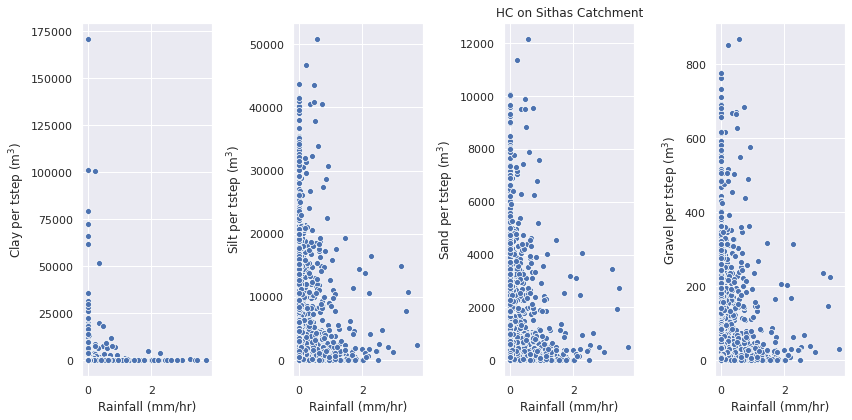

In [14]:
plt.figure(figsize=(12,6))
ax1 = plt.subplot(141)
g = sns.scatterplot(sithas_all['Rainfall'], sithas_all['Clay'], ax=ax1)
g.set_xlabel(g.get_xlabel() + ' (mm/hr)')
g.set_ylabel(g.get_ylabel() + ' per tstep (m$^3$)')
ax1 = plt.subplot(142)
g = sns.scatterplot(sithas_all['Rainfall'], sithas_all['Silt'], ax=ax1)
g.set_xlabel(g.get_xlabel() + ' (mm/hr)')
g.set_ylabel(g.get_ylabel() + ' per tstep (m$^3$)')
ax2 = plt.subplot(143)
g = sns.scatterplot(sithas_all['Rainfall'], sithas_all['Sand'], ax=ax2)
g.set_xlabel(g.get_xlabel() + ' (mm/hr)')
g.set_ylabel(g.get_ylabel() + ' per tstep (m$^3$)')
plt.title('HC on Sithas Catchment')
ax3 = plt.subplot(144)
g = sns.scatterplot(sithas_all['Rainfall'], sithas_all['Gravel'], ax=ax3)
g.set_xlabel(g.get_xlabel() + ' (mm/hr)')
g.set_ylabel(g.get_ylabel() + ' per tstep (m$^3$)')
plt.tight_layout()
plt.savefig('sithas_4g.png')
plt.show()

In [15]:
windows = [5, 10, 20]
for window in windows:
    
    sithas_all['Rainfall Rolling Std. ' + str(window)] = sithas_all['Rainfall'].rolling(window).std().values
    sithas_all['Rainfall Rolling Mean. ' + str(window)] = sithas_all['Rainfall'].rolling(window).mean().values
    sithas_all['Rainfall Rolling Median. ' + str(window)] = sithas_all['Rainfall'].rolling(window).median().values
    
    sithas_all['Clay Rolling Std. ' + str(window)] = sithas_all['Clay'].rolling(window).std().values
    sithas_all['Clay Rolling Mean. ' + str(window)] = sithas_all['Clay'].rolling(window).mean().values
    sithas_all['Clay Rolling Median. ' + str(window)] = sithas_all['Clay'].rolling(window).median().values
    
    sithas_all['Silt Rolling Std. ' + str(window)] = sithas_all['Silt'].rolling(window).std().values
    sithas_all['Silt Rolling Mean. ' + str(window)] = sithas_all['Silt'].rolling(window).mean().values
    sithas_all['Silt Rolling Median. ' + str(window)] = sithas_all['Silt'].rolling(window).median().values
    
    sithas_all['Sand Rolling Std. ' + str(window)] = sithas_all['Sand'].rolling(window).std().values
    sithas_all['Sand Rolling Mean. ' + str(window)] = sithas_all['Sand'].rolling(window).mean().values
    sithas_all['Sand Rolling Median. ' + str(window)] = sithas_all['Sand'].rolling(window).median().values
    
    sithas_all['Gravel Rolling Std. ' + str(window)] = sithas_all['Gravel'].rolling(window).std().values
    sithas_all['Gravel Rolling Mean. ' + str(window)] = sithas_all['Gravel'].rolling(window).mean().values
    sithas_all['Gravel Rolling Median. ' + str(window)] = sithas_all['Gravel'].rolling(window).median().values

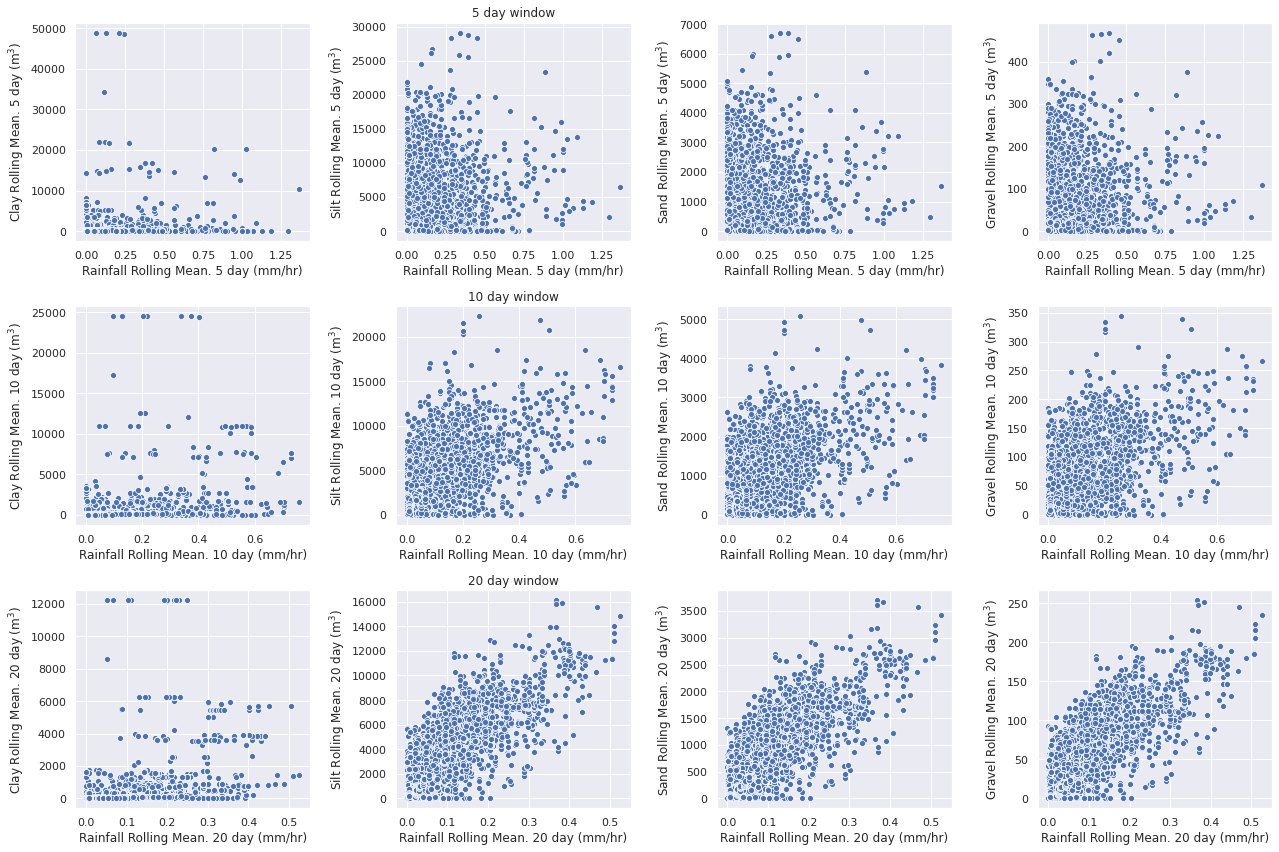

In [16]:
plt.figure(figsize=(18,12))

nplot = 0
for window in windows:
    nplot += 1
    ax1 = plt.subplot(3, 4, nplot)
    g = sns.scatterplot(sithas_all['Rainfall Rolling Mean. ' + str(window)],
                        sithas_all['Clay Rolling Mean. ' + str(window)], ax=ax1)
    g.set_xlabel(g.get_xlabel() + ' day (mm/hr)')
    g.set_ylabel(g.get_ylabel() + ' day (m$^3$)')
    nplot += 1
    ax2 = plt.subplot(3, 4, nplot)
    g = sns.scatterplot(sithas_all['Rainfall Rolling Mean. ' + str(window)],
                        sithas_all['Silt Rolling Mean. ' + str(window)], ax=ax2)
    g.set_xlabel(g.get_xlabel() + ' day (mm/hr)')
    g.set_ylabel(g.get_ylabel() + ' day (m$^3$)')
    plt.title(str(window) + ' day window')
    nplot += 1
    ax3 = plt.subplot(3, 4, nplot)
    g = sns.scatterplot(sithas_all['Rainfall Rolling Mean. ' + str(window)],
                        sithas_all['Sand Rolling Mean. ' + str(window)], ax=ax3)
    g.set_xlabel(g.get_xlabel() + ' day (mm/hr)')
    g.set_ylabel(g.get_ylabel() + ' day (m$^3$)')
    nplot += 1
    ax4 = plt.subplot(3, 4, nplot)
    g = sns.scatterplot(sithas_all['Rainfall Rolling Mean. ' + str(window)],
                        sithas_all['Gravel Rolling Mean. ' + str(window)], ax=ax4)
    g.set_xlabel(g.get_xlabel() + ' day (mm/hr)')
    g.set_ylabel(g.get_ylabel() + ' day (m$^3$)')
    
plt.tight_layout()
plt.show()

In the above series of plots it can be seen that if the suspended transport only applies to the clay facies then the resulting sediment yield becomes significantly more non-linear in the relationship between yield and precipitation. For the particles transported as bed load (silt, sand and gravel), there is a linear correlation between the 20 day rolling mean, however for the clay particles in suspension the relationship is still non-linear. The trouble with this result is the input sediment proportions are unrealistic, as silt should likewise be treated as a suspended load. Therefore potentially treating the silt as a large bedload fraction is creating a unrealistic result.

Another point to notice is that by treating the 32 micron particles as bedload the distribution of deposition in the catchment is very different. When I have four grain sizes in transport with only the smallest in suspension then the majority, 66%, travels along the bed. This means there is a greater quantity of material deposited within the catchment. Perhaps this is what causes the increased non-linear response, as only parts of the catchement can react to changing rainfall.

## HC with no depth to bedrock and three grain sizes (suspended, sand and gravel)

In this test I use a fall velocity of 0.00083 m/sec.

| Facies | Proportion | Grain size (m) | Fall velocity |
| --- | --- | --- | --- |
| Suspended | 0.87 | 0.00003 | 0.00083 |
| Sand | 0.13 | 0.0005 | - |
| Gravel | 0.01 | 0.004 | - |

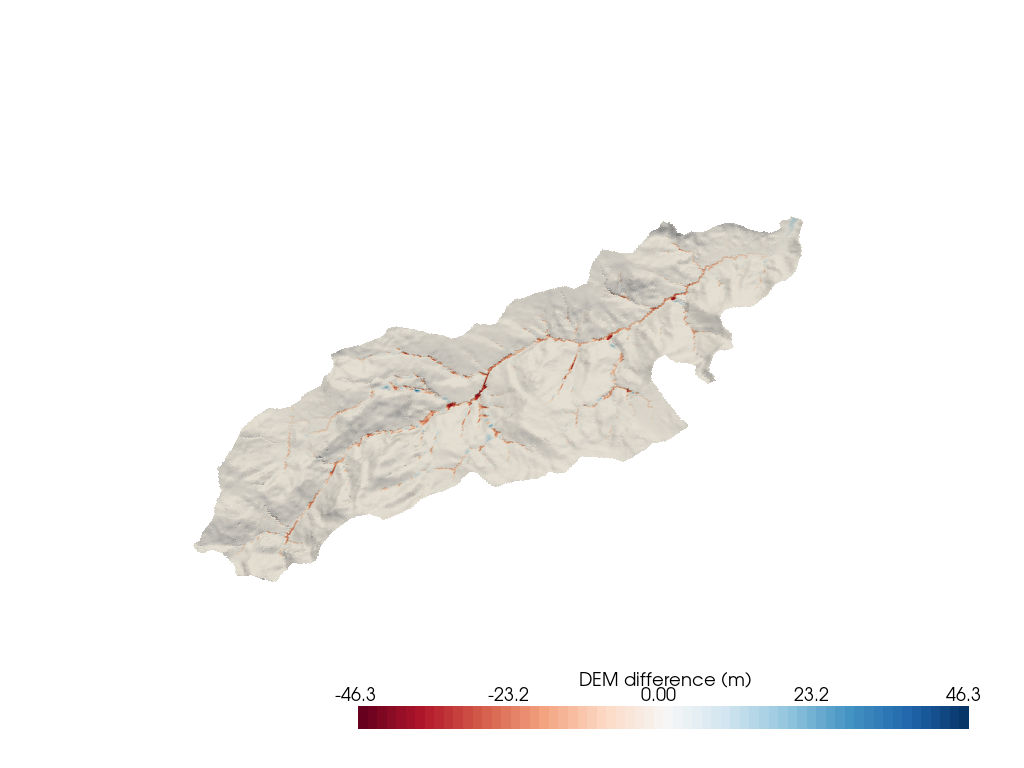

[(1069.0495742663963, 29034.111992089165, 53318.503286205276),
 (9225.0, 11075.0, 1186.6665744781494),
 (0.2969121238555084, -0.8875739108330448, 0.35221547881395754)]

In [17]:
ascfile = '/work/armitagj/runs/caesar-explore/ener440/sithas_0_00083vfall/results/Elevations7344000.asc'
ncols, nrows, geotransform, data_array = cp.demio.asc2numpy(ascfile)
dXY = geotransform[1]
xcorner = np.linspace(0.5*dXY, (ncols-0.5)*dXY, ncols)
ycorner = np.linspace(0.5*dXY, (nrows-0.5)*dXY, nrows)
z = np.fliplr(data_array)
x,y = np.meshgrid(xcorner, ycorner)
grid = pv.StructuredGrid(x, y, z)
d = np.zeros_like(grid.points)
d[:, 1] = grid.points[:, 2]

ascfile = '/work/armitagj/runs/caesar-explore/ener440/sithas_0_00083vfall/results/Elevations0.asc'
ncols, nrows, geotransform, data_array = cp.demio.asc2numpy(ascfile)
z0 = pv.StructuredGrid(x, y, np.fliplr(data_array))
d0 = np.zeros_like(z0.points)
d0[:, 1] = z0.points[:, 2]

cpos = [(1069.0495742663963, 29034.111992089165, 53318.503286205276),
        (9225.0, 11075.0, 1186.6665744781494),
        (0.29691212385550847, -0.887573910833045, 0.3522154788139576)]

clim = np.nanmax(np.abs(d[:,1] - d0[:,1]))
p = pv.Plotter(notebook=True)
p.add_mesh(grid, scalars=d[:,1] - d0[:,1], cmap='RdBu', clim=[-clim, clim])
p.camera_position = cpos
p.add_scalar_bar(title='DEM difference (m)')
p.show(screenshot='caesar.png')

<Figure size 1080x1080 with 0 Axes>

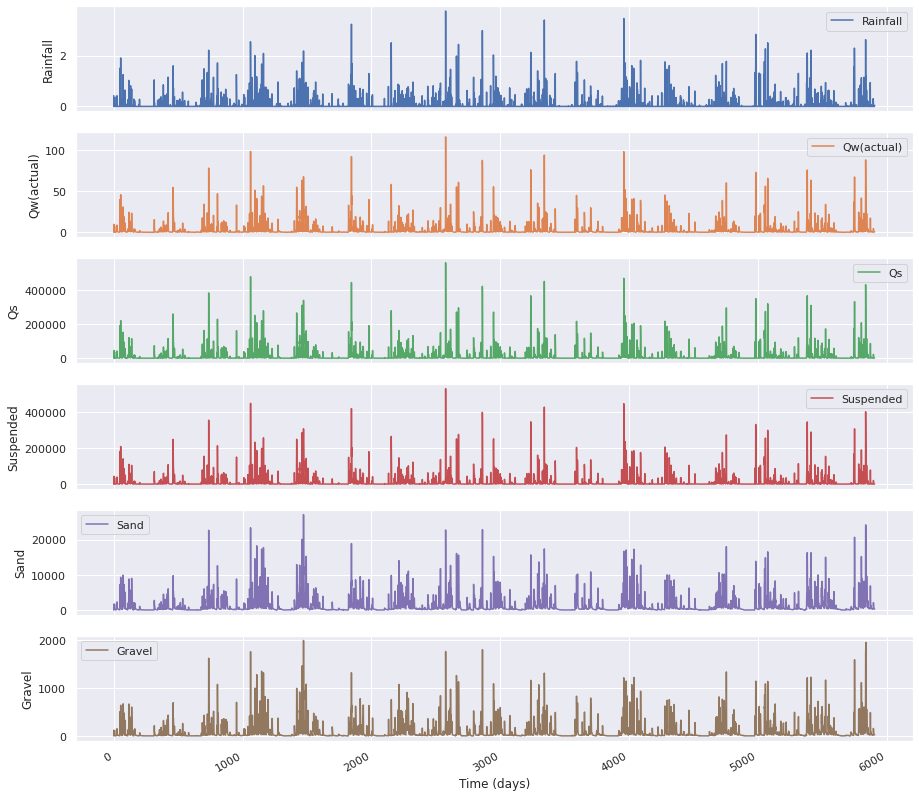

In [18]:
file = '/work/armitagj/runs/caesar-explore/ener440/sithas_0_00083vfall/results/Sithas_v7.dat'
sithas_ = pd.read_csv(file, sep=' ', index_col=False,
                       names=['Time Step', 'Qw(actual)', 'Qw(expected)', 'Blank', 'Qs', 'Suspended', 'Sand', 'Gravel'])
file = '/work/armitagj/runs/caesar-explore/ener440/sithas/input_data/Chalkio_rain.txt'
sithas_rain = pd.read_csv(file, sep=' ', index_col=False,
                       names=['Rainfall'])
sithas_all = pd.concat([sithas_, sithas_rain], axis=1, sort=False).dropna()
sns.set(rc={'figure.figsize':(15, 15)})
plt.figure()
cols_plot = ['Rainfall', 'Qw(actual)', 'Qs', 'Suspended', 'Sand', 'Gravel']
axes = sithas_all[cols_plot].plot(marker='', alpha=1, subplots=True)
i = 0
for ax in axes:
    ax.set_ylabel(cols_plot[i])
    i += 1
plt.xlabel('Time (days)')
plt.savefig('sithas_tseries.png')
plt.show()

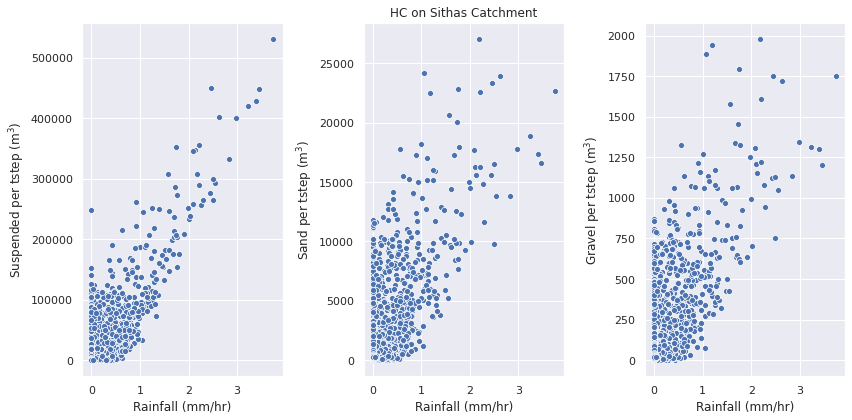

In [19]:
plt.figure(figsize=(12,6))
ax1 = plt.subplot(131)
g = sns.scatterplot(sithas_all['Rainfall'], sithas_all['Suspended'], ax=ax1)
g.set_xlabel(g.get_xlabel() + ' (mm/hr)')
g.set_ylabel(g.get_ylabel() + ' per tstep (m$^3$)')
ax2 = plt.subplot(132)
g = sns.scatterplot(sithas_all['Rainfall'], sithas_all['Sand'], ax=ax2)
g.set_xlabel(g.get_xlabel() + ' (mm/hr)')
g.set_ylabel(g.get_ylabel() + ' per tstep (m$^3$)')
plt.title('HC on Sithas Catchment')
ax3 = plt.subplot(133)
g = sns.scatterplot(sithas_all['Rainfall'], sithas_all['Gravel'], ax=ax3)
g.set_xlabel(g.get_xlabel() + ' (mm/hr)')
g.set_ylabel(g.get_ylabel() + ' per tstep (m$^3$)')
plt.tight_layout()
plt.savefig('sithas.png')
plt.show()

Reducing the settling velocity to a more reasonable value gives a result that has once more a linear trend for the sediment yield versus the rainfall input.

## HC with bedrock and three grain sizes (suspended, sand and gravel)

Here we have an erodable surface and a bedrock below which can erode:

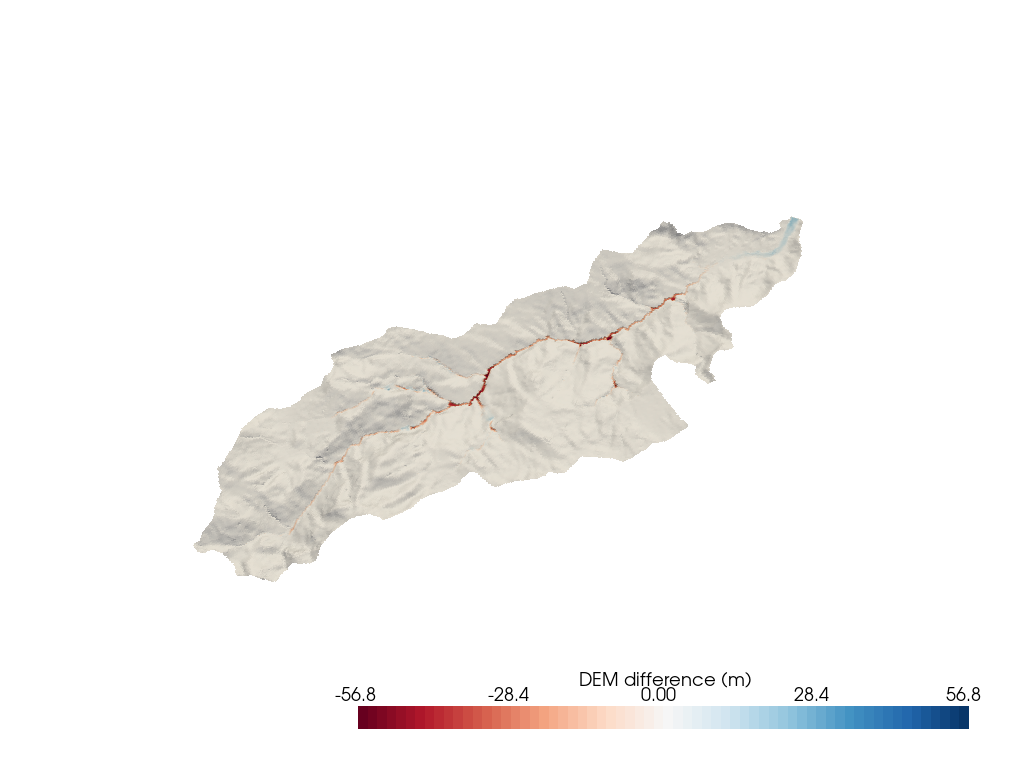

[(1069.0495742663963, 29034.111992089165, 53318.503286205276),
 (9225.0, 11075.0, 1186.6665744781494),
 (0.2969121238555084, -0.8875739108330448, 0.35221547881395754)]

In [20]:
ascfile = '/work/armitagj/runs/caesar-explore/ener440/sithas_bedrock/results/Elevations7344000.asc'
ncols, nrows, geotransform, data_array = cp.demio.asc2numpy(ascfile)
dXY = geotransform[1]
xcorner = np.linspace(0.5*dXY, (ncols-0.5)*dXY, ncols)
ycorner = np.linspace(0.5*dXY, (nrows-0.5)*dXY, nrows)
z = np.fliplr(data_array)
x,y = np.meshgrid(xcorner, ycorner)
grid = pv.StructuredGrid(x, y, z)
d = np.zeros_like(grid.points)
d[:, 1] = grid.points[:, 2]

ascfile = '/work/armitagj/runs/caesar-explore/ener440/sithas_bedrock/results/Elevations0.asc'
ncols, nrows, geotransform, data_array = cp.demio.asc2numpy(ascfile)
z0 = pv.StructuredGrid(x, y, np.fliplr(data_array))
d0 = np.zeros_like(z0.points)
d0[:, 1] = z0.points[:, 2]

cpos = [(1069.0495742663963, 29034.111992089165, 53318.503286205276),
        (9225.0, 11075.0, 1186.6665744781494),
        (0.29691212385550847, -0.887573910833045, 0.3522154788139576)]

clim = np.nanmax(np.abs(d[:,1] - d0[:,1]))
p = pv.Plotter(notebook=True)
p.add_mesh(grid, scalars=d[:,1] - d0[:,1], cmap='RdBu', clim=[-clim, clim])
p.camera_position = cpos
p.add_scalar_bar(title='DEM difference (m)')
p.show(screenshot='CL_sithas_bedrock_DEMdiff.png')

There is still significant erosion within the central channel. This is likely because of the coarse nature of the input depth to bedrock taken from the soil thickness map. We likely need a more accurate thickness for transportable material, which could be taken from satellite images. This might be a major area for study to get more accurate simulations for the quantity of erosion and the change in sediment yield due to change in precipitation.

<Figure size 1080x1080 with 0 Axes>

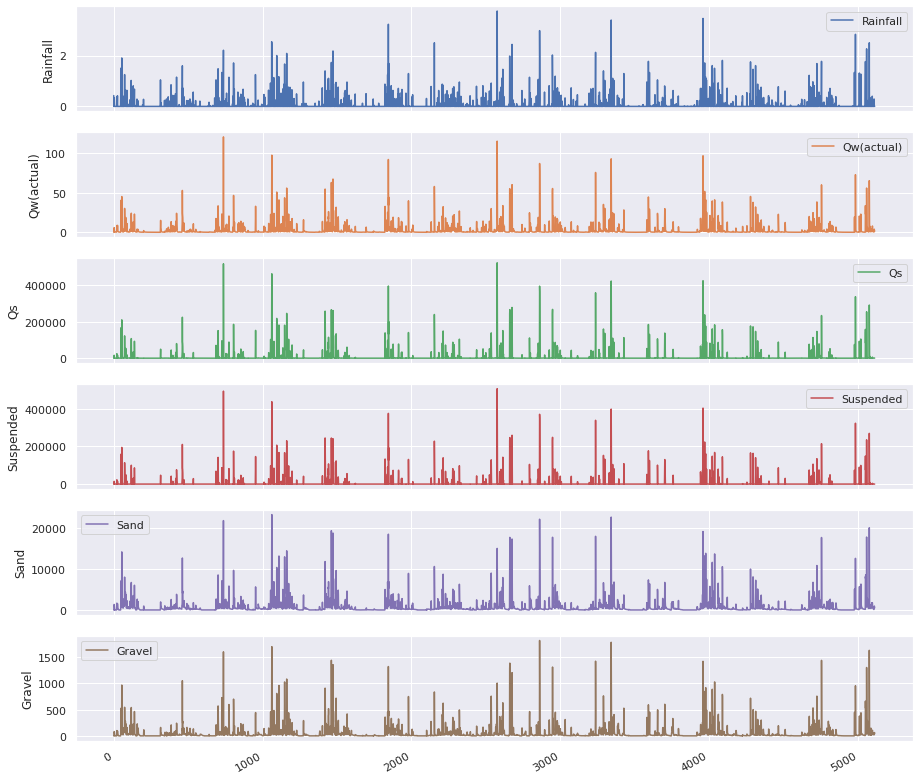

In [21]:
file = '/work/armitagj/runs/caesar-explore/ener440/sithas_bedrock/results/Sithas_v7.dat'
sithas_ = pd.read_csv(file, sep=' ', index_col=False,
                       names=['Time Step', 'Qw(actual)', 'Qw(expected)', 'Blank', 'Qs', 'Suspended', 'Sand', 'Gravel'])
file = '/work/armitagj/runs/caesar-explore/ener440/sithas/input_data/Chalkio_rain.txt'
sithas_rain = pd.read_csv(file, sep=' ', index_col=False,
                       names=['Rainfall'])
sithas_all = pd.concat([sithas_, sithas_rain], axis=1, sort=False).dropna()
sns.set(rc={'figure.figsize':(15, 15)})
plt.figure()
cols_plot = ['Rainfall', 'Qw(actual)', 'Qs', 'Suspended', 'Sand', 'Gravel']
axes = sithas_all[cols_plot].plot(marker='', alpha=1, subplots=True)
i = 0
for ax in axes:
    ax.set_ylabel(cols_plot[i])
    i += 1
plt.show()

The response to precipitation change is similar in magnitude to the model without bedrock, but again this could be due to the thickness of the transportable material within the model.

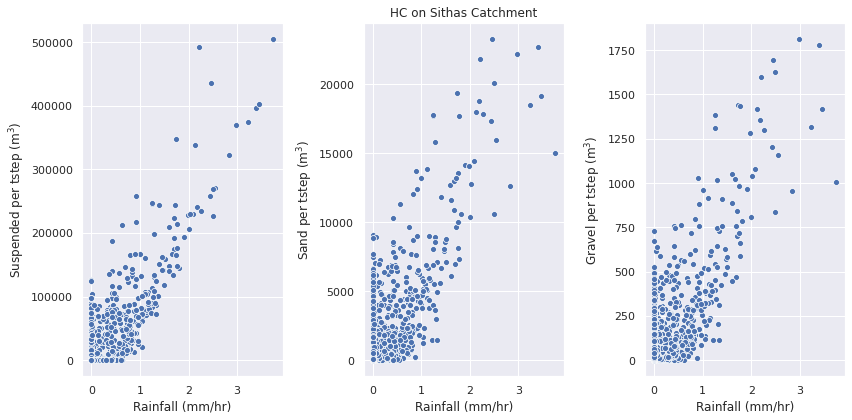

In [22]:
plt.figure(figsize=(12,6))
ax1 = plt.subplot(131)
g = sns.scatterplot(sithas_all['Rainfall'], sithas_all['Suspended'], ax=ax1)
g.set_xlabel(g.get_xlabel() + ' (mm/hr)')
g.set_ylabel(g.get_ylabel() + ' per tstep (m$^3$)')
ax2 = plt.subplot(132)
g = sns.scatterplot(sithas_all['Rainfall'], sithas_all['Sand'], ax=ax2)
g.set_xlabel(g.get_xlabel() + ' (mm/hr)')
g.set_ylabel(g.get_ylabel() + ' per tstep (m$^3$)')
plt.title('HC on Sithas Catchment')
ax3 = plt.subplot(133)
g = sns.scatterplot(sithas_all['Rainfall'], sithas_all['Gravel'], ax=ax3)
g.set_xlabel(g.get_xlabel() + ' (mm/hr)')
g.set_ylabel(g.get_ylabel() + ' per tstep (m$^3$)')
plt.tight_layout()
plt.show()

The relationship between sediment yield and rainfall is very similar to the model without bedrock. Below I will explore the relationship a bit further.

In [23]:
windows = [3, 5, 10]
for window in windows:
    
    sithas_all['Rainfall Rolling Std. ' + str(window)] = sithas_all['Rainfall'].rolling(window).std().values
    sithas_all['Rainfall Rolling Mean. ' + str(window)] = sithas_all['Rainfall'].rolling(window).mean().values
    sithas_all['Rainfall Rolling Median. ' + str(window)] = sithas_all['Rainfall'].rolling(window).median().values
    
    sithas_all['Suspended Rolling Std. ' + str(window)] = sithas_all['Suspended'].rolling(window).std().values
    sithas_all['Suspended Rolling Mean. ' + str(window)] = sithas_all['Suspended'].rolling(window).mean().values
    sithas_all['Suspended Rolling Median. ' + str(window)] = sithas_all['Suspended'].rolling(window).median().values
    
    sithas_all['Sand Rolling Std. ' + str(window)] = sithas_all['Sand'].rolling(window).std().values
    sithas_all['Sand Rolling Mean. ' + str(window)] = sithas_all['Sand'].rolling(window).mean().values
    sithas_all['Sand Rolling Median. ' + str(window)] = sithas_all['Sand'].rolling(window).median().values
    
    sithas_all['Gravel Rolling Std. ' + str(window)] = sithas_all['Gravel'].rolling(window).std().values
    sithas_all['Gravel Rolling Mean. ' + str(window)] = sithas_all['Gravel'].rolling(window).mean().values
    sithas_all['Gravel Rolling Median. ' + str(window)] = sithas_all['Gravel'].rolling(window).median().values

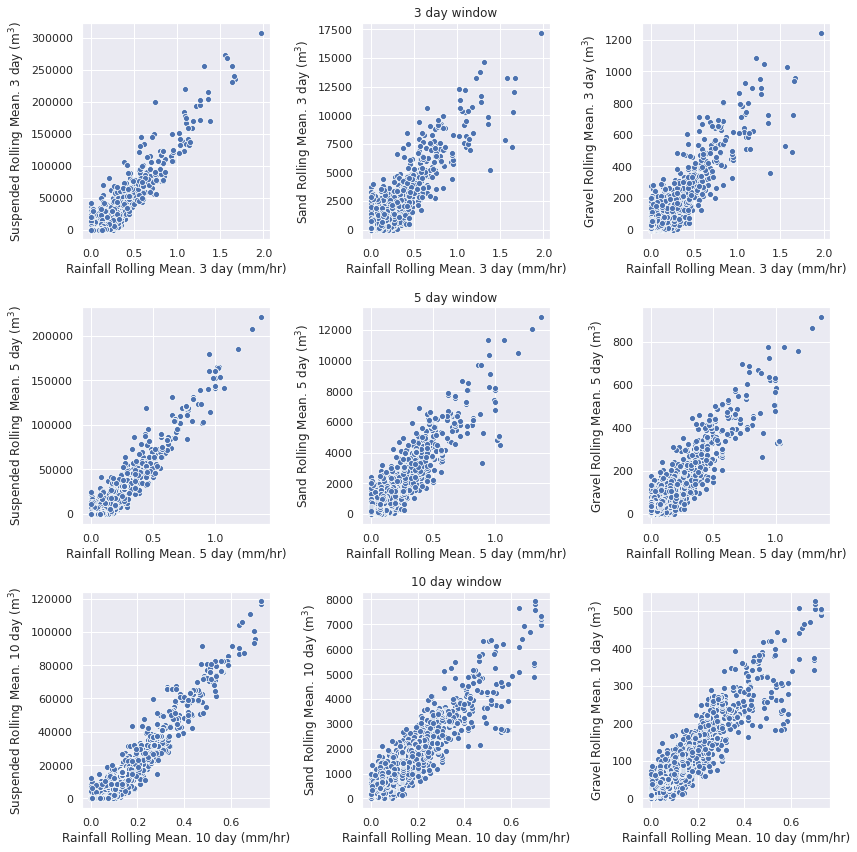

In [24]:
plt.figure(figsize=(12,12))

nplot = 330
for window in windows:
    nplot += 1
    ax1 = plt.subplot(nplot)
    g = sns.scatterplot(sithas_all['Rainfall Rolling Mean. ' + str(window)],
                        sithas_all['Suspended Rolling Mean. ' + str(window)], ax=ax1)
    g.set_xlabel(g.get_xlabel() + ' day (mm/hr)')
    g.set_ylabel(g.get_ylabel() + ' day (m$^3$)')
    nplot += 1
    ax2 = plt.subplot(nplot)
    g = sns.scatterplot(sithas_all['Rainfall Rolling Mean. ' + str(window)],
                        sithas_all['Sand Rolling Mean. ' + str(window)], ax=ax2)
    g.set_xlabel(g.get_xlabel() + ' day (mm/hr)')
    g.set_ylabel(g.get_ylabel() + ' day (m$^3$)')
    plt.title(str(window) + ' day window')
    nplot += 1
    ax3 = plt.subplot(nplot)
    g = sns.scatterplot(sithas_all['Rainfall Rolling Mean. ' + str(window)],
                        sithas_all['Gravel Rolling Mean. ' + str(window)], ax=ax3)
    g.set_xlabel(g.get_xlabel() + ' day (mm/hr)')
    g.set_ylabel(g.get_ylabel() + ' day (m$^3$)')
    
plt.tight_layout()
plt.show()

The plots above show a very similar trend as to when there is assumed to be no bedrock.

# Observations from real catchments

For comparison I will plot the relationship between sediment yield and water flux for some catchments from USGS stations.

In [35]:
def plot_station(stationID, QwID, QsID, title, ax):
    file = '/work/armitagj/Documents/MPH03001-benchmark/data/USGS/USGS-{:08d}.txt'.format(np.int(stationID))
    df = pd.read_csv(file, comment='#', delimiter='\t')
    df = df[~df['agency_cd'].str.contains('5s')]
    df[QwID] = df[QwID].astype(float)
    df[QsID] = df[QsID].astype(float)
    model = sm.OLS(df[QsID],sm.add_constant(df[QwID]),missing='drop').fit()
    xx = np.arange(np.min(df[QwID]), np.max(df[QwID]))
    yy = model.params[0] + xx*model.params[1]
    g = sns.scatterplot(x=QwID, y=QsID, data=df, ax=ax)
    plt.plot(xx, yy, 'k')
    plt.xlabel('Discharge, ft$^3$/sec')
    plt.ylabel('Suspended Sediment, short tons/day')
    plt.title(title)
    plt.text(0.05, np.max(df[QsID]), 'R² = ' + str(np.round(model.rsquared,3)))
    return model.rsquared

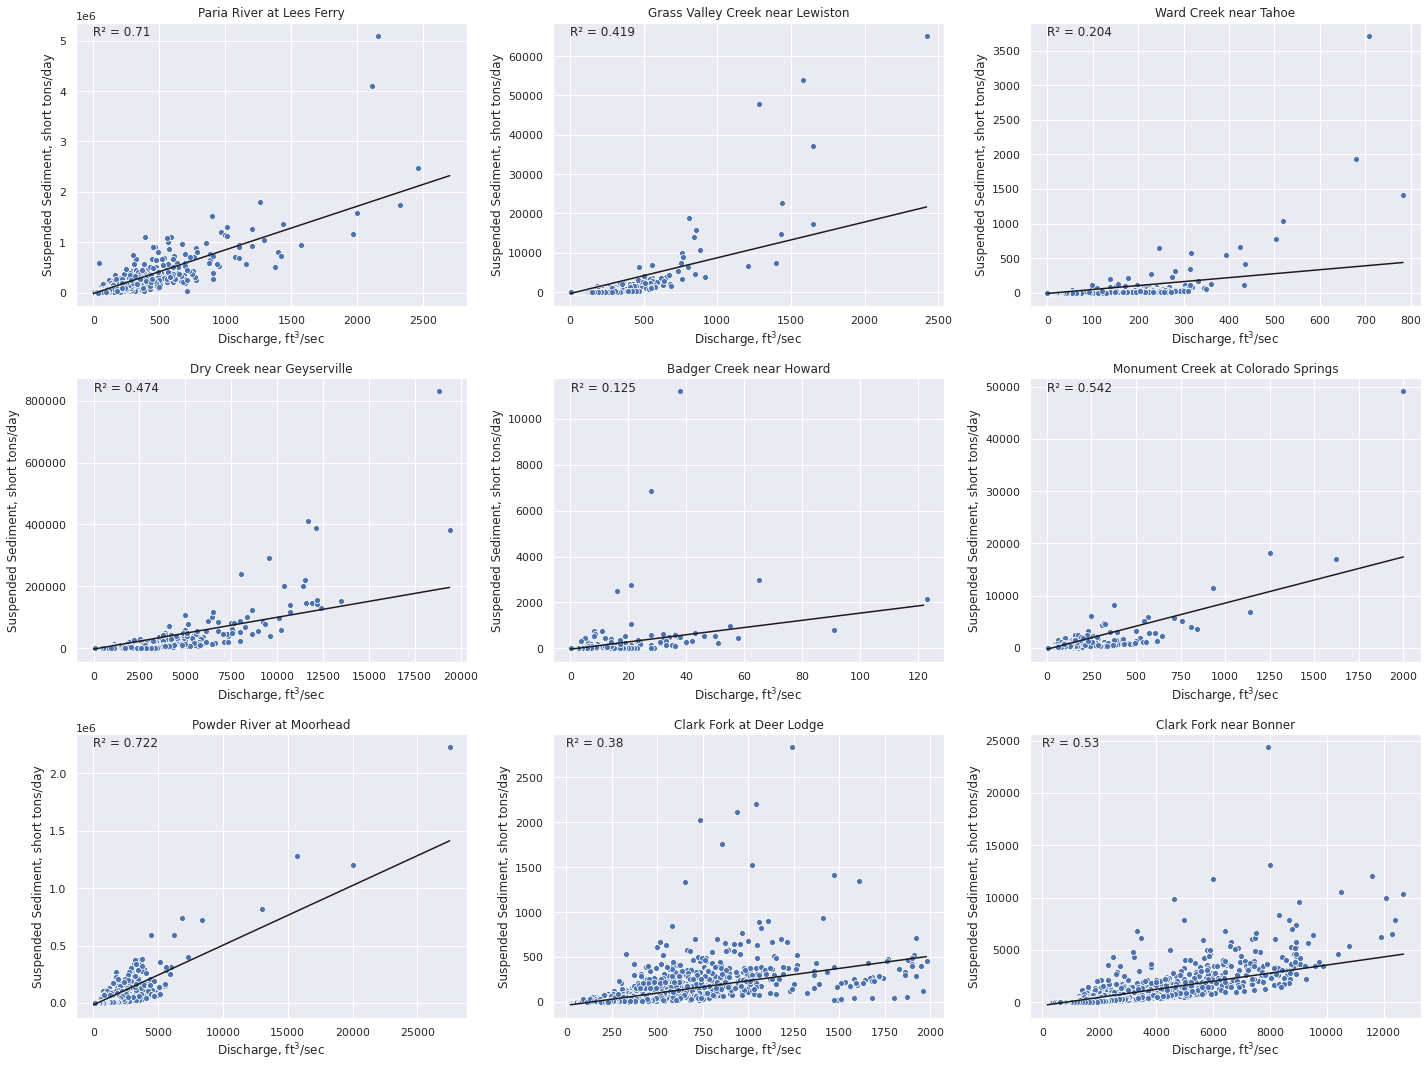

In [36]:
file = '/work/armitagj/Documents/MPH03001-benchmark/data/EastSankey_TableS1.csv'
df = pd.read_csv(file, skiprows=[i for i in range(0,2)], delimiter=',')

sns.set(rc={'figure.figsize':(20, 15)})
pdx = 330
plt.figure()
for i in range(1, 10):
    pdx += 1
    ax = plt.subplot(pdx)
    resid = plot_station(df['Station ID number'][i], df['QwID'][i], df['QsID'][i], df['Gaging station name'][i], ax)
    plt.tight_layout()
plt.savefig('usgs_data.png', dpi=600)
plt.show()

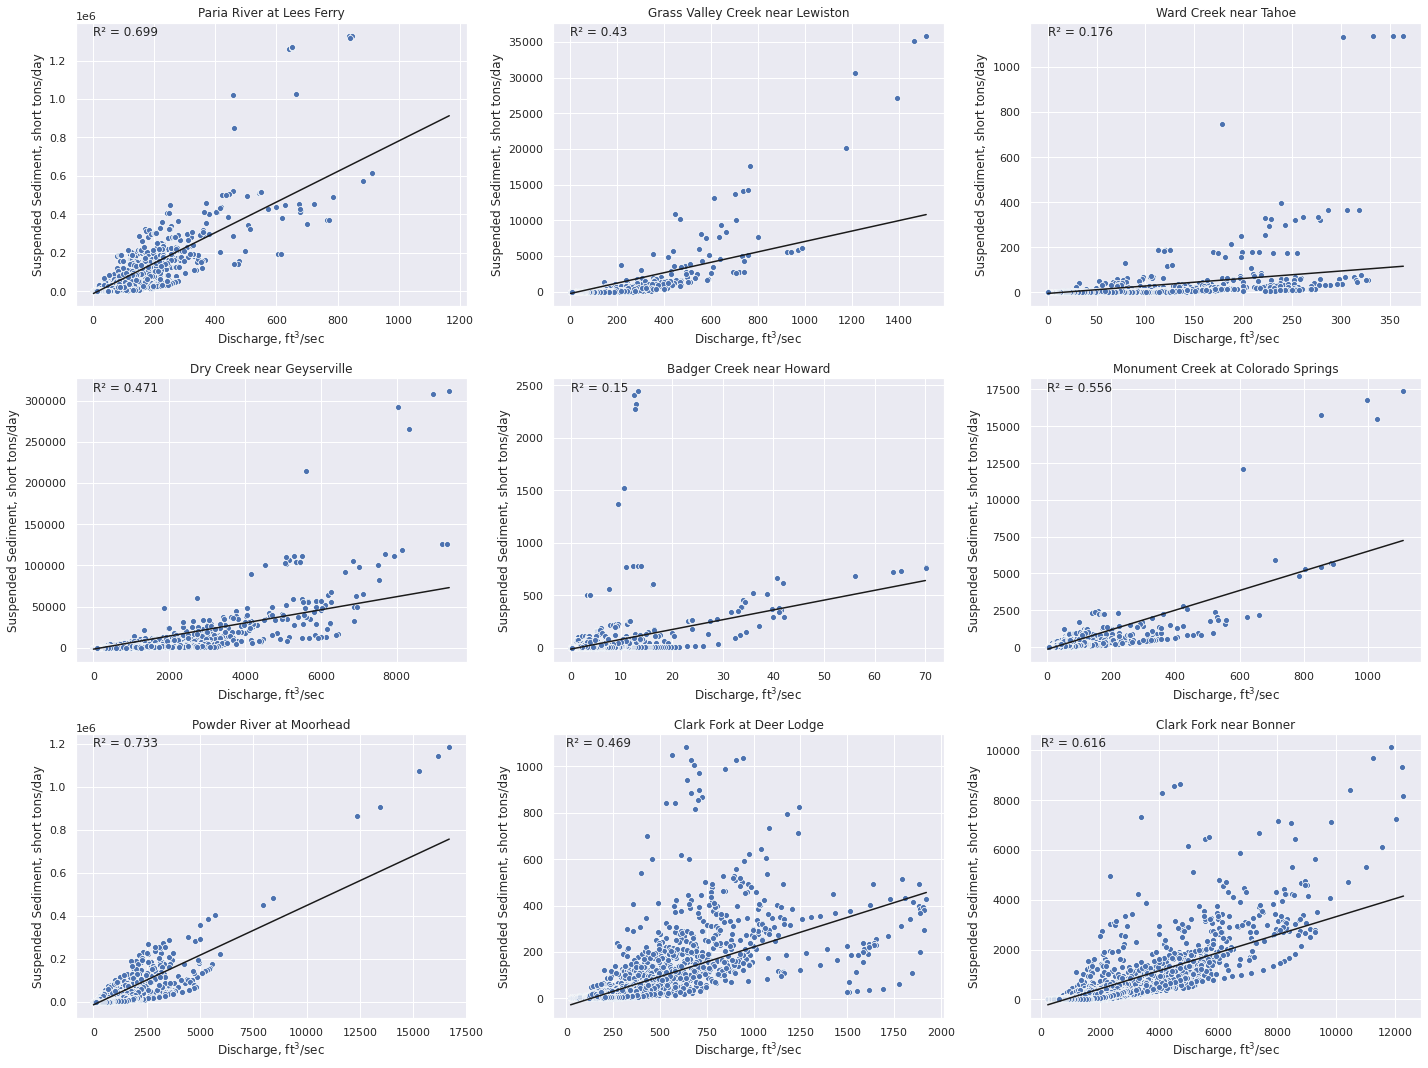

In [41]:
def plot_rolling_station(stationID, QwID, QsID, title, ax):
    file = '/work/armitagj/Documents/MPH03001-benchmark/data/USGS/USGS-{:08d}.txt'.format(np.int(stationID))
    df = pd.read_csv(file, comment='#', delimiter='\t')
    df = df[~df['agency_cd'].str.contains('5s')]
    df[QwID] = df[QwID].astype(float)
    df[QsID] = df[QsID].astype(float)
    window = 5
    df[QwID + str(window)] = df[QwID].rolling(window).mean().values
    df[QsID + str(window)] = df[QsID].rolling(window).mean().values
    model = sm.OLS(df[QsID + str(window)],sm.add_constant(df[QwID + str(window)]),missing='drop').fit()
    xx = np.arange(np.min(df[QwID + str(window)]), np.max(df[QwID + str(window)]))
    yy = model.params[0] + xx*model.params[1]
    g = sns.scatterplot(x=QwID + str(window), y=QsID + str(window), data=df, ax=ax)
    plt.plot(xx, yy, 'k')
    plt.xlabel('Discharge, ft$^3$/sec')
    plt.ylabel('Suspended Sediment, short tons/day')
    plt.text(0.05, np.max(df[QsID + str(window)]), 'R² = ' + str(np.round(model.rsquared,3)))
    plt.title(title)

file = '/work/armitagj/Documents/MPH03001-benchmark/data/EastSankey_TableS1.csv'
df = pd.read_csv(file, skiprows=[i for i in range(0,2)], delimiter=',')

sns.set(rc={'figure.figsize':(20, 15)})
pdx = 330
plt.figure()
for i in range(1, 10):
    pdx += 1
    ax = plt.subplot(pdx)
    plot_rolling_station(df['Station ID number'][i], df['QwID'][i], df['QsID'][i], df['Gaging station name'][i], ax)
plt.tight_layout()
plt.savefig('usgs_data_rolling.png', dpi=600)
plt.show()

# Thoughts for future modelling related to Sithas and the coastline

Below I will outline a few ideas that arise from these tests of CL. There is first the issue of the choice of what clasts to that as an aggregated suspended sediment. Secondly there remains some work to do in defining the depth to bedrock within the model.

1. The system where I treated only clay as a suspended sediment has a behaviour that is quite different from when I lumped together clay and silt into a aggregated suspended clast. This is because when the silt was treated as a bedload it clogged the tributaries to the river Sithas. This blockage caused the suspended clay sediment yield to be very non-linear.

2. If I take the more realistic, I think, assumption that both silt and clay are transported as suspended sediment then the sediment yield is relatively linear, and each rainfall event generates a response. The main channel of the River Sithas is highly eroded however. This could be adjusted by modifying the depth to bedrock.

3. There are therefore two input parameters that need to be explored, the depth to bedrock and the grain size proportions.

4. Currently CL is generating linear trends when precipitation is plotted against sediment yield, however there is some evidence that in nature the trend might follow a power law.
